In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from galpy.util.bovy_coords import *
from search_local import *

gaia_data = search_phase_space(0., 0., 0., 0., 0., 0., 0.5, 0.)
R, phi, z = rect_to_cyl(gaia_data[:,0], gaia_data[:,1], gaia_data[:,2])
vR, vT, vz = rect_to_cyl_vec(gaia_data[:,3], gaia_data[:,4], gaia_data[:,5], gaia_data[:,0], gaia_data[:,1], gaia_data[:,2])
gaia_data = np.stack((R, phi, z, vR, vT, vz), axis=1)

print('#stars', len(gaia_data))
print('min/max/mean (R)', min(gaia_data[:,0]), max(gaia_data[:,0]), np.mean(gaia_data[:,0]))
print('min/max/mean (phi)', min(gaia_data[:,1]), max(gaia_data[:,1]), np.mean(gaia_data[:,1]))
print('min/max/mean (z)', min(gaia_data[:,2]), max(gaia_data[:,2]), np.mean(gaia_data[:,2]))
print('min/max/mean (vR)', min(gaia_data[:,3]), max(gaia_data[:,3]), np.mean(gaia_data[:,3]))
print('min/max/mean (vT)', min(gaia_data[:,4]), max(gaia_data[:,4]), np.mean(gaia_data[:,4]))
print('min/max/mean (vz)', min(gaia_data[:,5]), max(gaia_data[:,5]), np.mean(gaia_data[:,5]))
print(np.std(gaia_data[:,0]), np.std(gaia_data[:,1]), np.std(gaia_data[:,2]), np.std(gaia_data[:,3]), np.std(gaia_data[:,4]), np.std(gaia_data[:,5]))

c:\users\ayush\anaconda3\lib\site-packages\astropy\coordinates\sky_coordinate.py:1786: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

#stars 1699708
min/max/mean (R) 7.800911997788074 8.799620277350543 8.291940989763331
min/max/mean (phi) 3.0813469383936956 3.2018352601712126 3.141300302894572
min/max/mean (z) -0.47224099228924643 0.5251864323212104 0.020554162071444157
min/max/mean (vR) -548.5939275793445 657.8733574312542 -1.0635896390181552
min/max/mean (vT) -908.3028370417318 407.85361294256495 -210.4756252801884
min/max/mean (vz) -392.75735712064113 374.51594061818395 -0.5273981260258953
0.19569240168043248 0.024711492153012812 0.16310598222016867 37.24396957743784 27.049247224061276 19.622803785914808


In [2]:
#Importing the required modules
import numpy as np
from sklearn.neighbors import KernelDensity

#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-07-15 - Updated - Ayush Pandhi
    """
    #Scaling velocities with z-score
    inputs_std = np.nanstd(inputs, axis=0)
    i1, i2, i3, i4, i5, i6 = np.mean(inputs, axis=0)
    inputs_mean = np.hstack((i1, i2, i3, i4, i5, i6))
    inputs = (inputs - inputs_mean)/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Multivariate Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    bw = 5 * np.nanstd(inputs) * N ** (-1/10.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-07-15 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = (samples - inputs_mean)/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_gaia_epanechnikov = generate_KDE(gaia_data, 'epanechnikov')

In [4]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(gaia_data[:,0])
mean_phi = np.ones((N, 1))*np.mean(gaia_data[:,1])
mean_z = np.ones((N, 1))*np.mean(gaia_data[:,2])
mean_vR = np.ones((N, 1))*np.mean(gaia_data[:,3])
mean_vT = np.ones((N, 1))*np.mean(gaia_data[:,4])
mean_vz = np.ones((N, 1))*np.mean(gaia_data[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(gaia_data[:,0]), max(gaia_data[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(gaia_data[:,1]), max(gaia_data[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(gaia_data[:,2]), max(gaia_data[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(gaia_data[:,3]), max(gaia_data[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(gaia_data[:,4]), max(gaia_data[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(gaia_data[:,5]), max(gaia_data[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

Variable R at Scotts bw


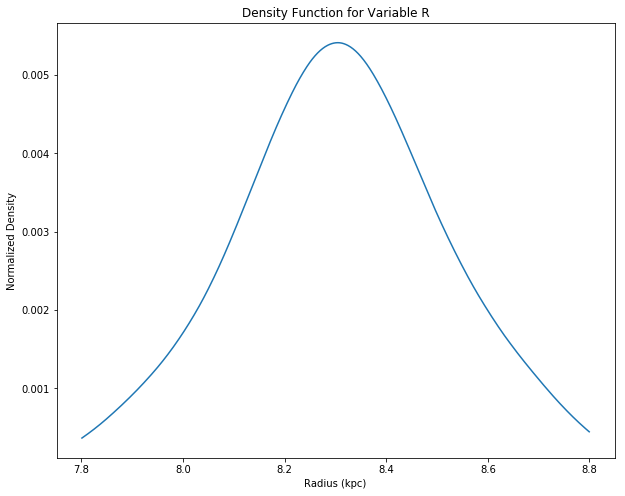

In [7]:
#Variable R plot
print('Variable R at Scotts bw')
plt.figure(figsize = (10, 8))
Rplot_epanechnikov = kde_gaia_epanechnikov(sample_R)
plt.plot(R_points, Rplot_epanechnikov)
plt.xlabel('Radius (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable R')
plt.savefig('gaia_zscore_cyl_variable_R')
plt.show()

Variable phi at Scotts bw


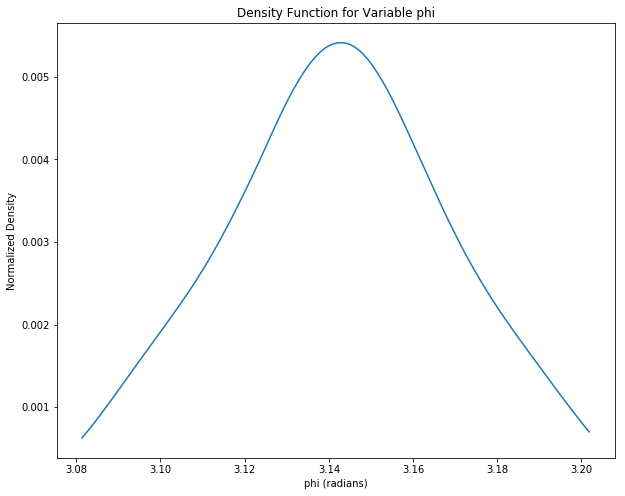

In [8]:
#Variable phi plot
print('Variable phi at Scotts bw')
plt.figure(figsize = (10, 8))
phiplot_epanechnikov = kde_gaia_epanechnikov(sample_phi)
plt.plot(phi_points, phiplot_epanechnikov)
plt.xlabel('phi (radians)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable phi')
plt.savefig('gaia_zscore_cyl_variable_phi')
plt.show()

Variable z at Scotts bw


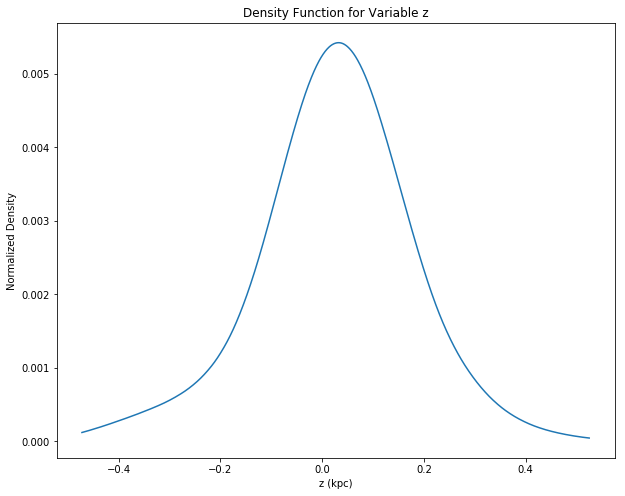

In [9]:
#Variable z plot
print('Variable z at Scotts bw')
plt.figure(figsize = (10, 8))
zplot_epanechnikov = kde_gaia_epanechnikov(sample_z)
plt.plot(z_points, zplot_epanechnikov)
plt.xlabel('z (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable z')
plt.savefig('gaia_zscore_cyl_variable_z')
plt.show()

Variable vR at Scotts bw


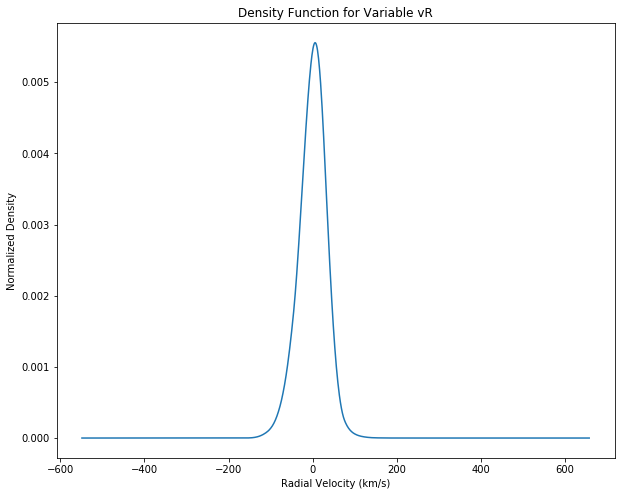

In [10]:
#Variable vR plot
print('Variable vR at Scotts bw')
plt.figure(figsize = (10, 8))
vRplot_epanechnikov = kde_gaia_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov)
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vR')
plt.savefig('gaia_zscore_cyl_variable_vR')
plt.show()

Variable vT at Scotts bw


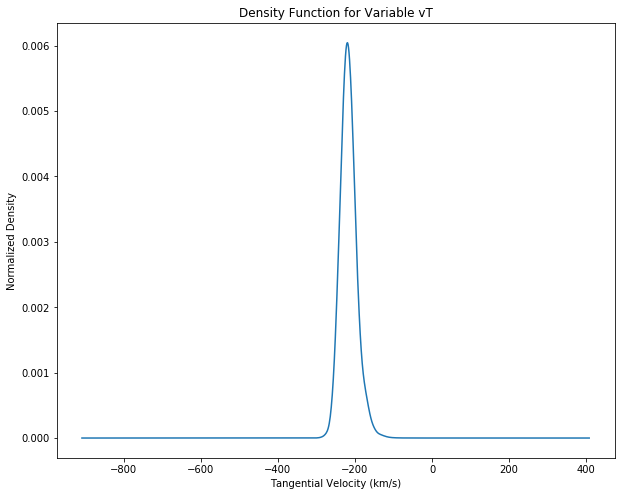

In [11]:
#Variable vT plot
print('Variable vT at Scotts bw')
plt.figure(figsize = (10, 8))
vTplot_epanechnikov = kde_gaia_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov)
plt.xlabel('Tangential Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vT')
plt.savefig('gaia_zscore_cyl_variable_vT')
plt.show()

Variable vz at Scotts bw


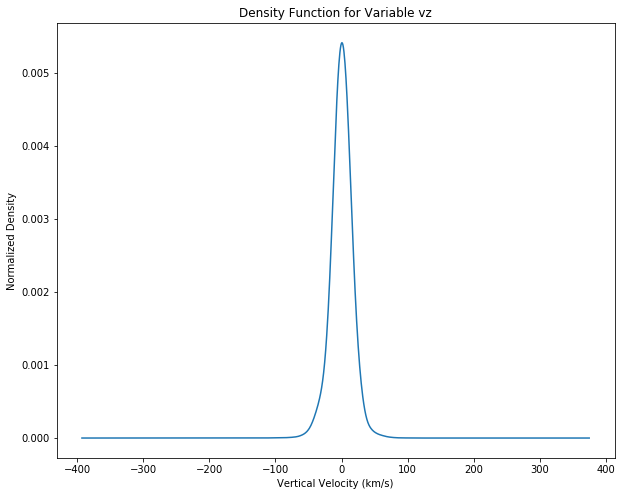

In [12]:
#Variable vz plot
print('Variable vz at Scotts bw')
plt.figure(figsize = (10, 8))
vzplot_epanechnikov = kde_gaia_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov)
plt.xlabel('Vertical Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vz')
plt.savefig('gaia_zscore_cyl_variable_vz')
plt.show()

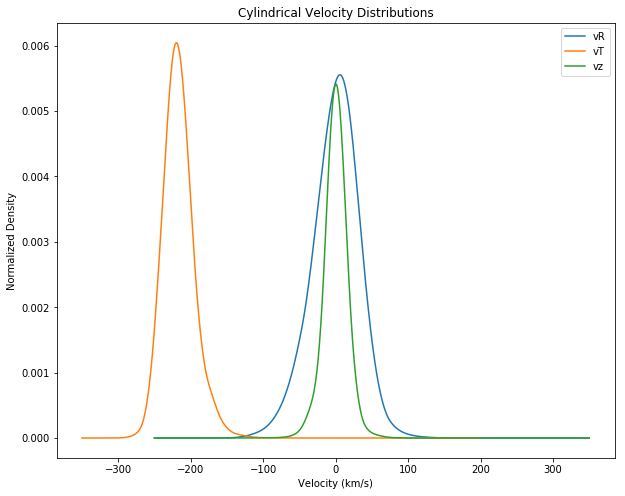

In [14]:
#For variable vR
vR_points = np.linspace(-250, 350, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-350, 200, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-250, 350, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities
plt.figure(figsize = (10, 8))

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_gaia_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov, label='vR')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_gaia_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov, label='vT')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_gaia_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov, label='vz')

#Show plot
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Cylindrical Velocity Distributions')
plt.legend()
plt.savefig('gaia_zscore_cyl_velocity_distribution')
plt.show()

In [16]:
from scipy.integrate import dblquad
import time

#input values for velocities (vR, vT, vz)
v_input = np.linspace(-400, 200, 100)

# -----------------
# Integrate over vR
# -----------------

def kde_gaia_cyl_vR(vT, vz, R, phi, z, vR):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vR(kde_gaia_epanechnikov, vR): #bounds of vT = [-300, 0], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_gaia_cyl_vR, -300, 0, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.001)  # args=(R, phi, z, vR)

vR_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_gaia_epanechnikov, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_gaia_cyl_vT(vR, vz, R, phi, z, vT):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vT(kde_gaia_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_gaia_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_gaia_epanechnikov, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_gaia_cyl_vz(vR, vT, R, phi, z, vz):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vz(kde_gaia_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [-300, 0]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_gaia_cyl_vz, -100, 100, -300, 0, args=([8.3, 3.14, 0., vz]), epsabs=0.001)  # args=(R, phi, z, vR)

vz_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_gaia_epanechnikov, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].
KDE Evaluations along vR from [-400, 200] over 100 subintervals.

Evaluation: 1
Evaluating at vR = -400.0
Value: 1.1429363375066618e-14
Time to integrate: 1.78s
Time elapsed: 0.03 min

Evaluation: 2
Evaluating at vR = -393.93939393939394
Value: 2.3156725592596382e-07
Time to integrate: 1.69s
Time elapsed: 0.06 min

Evaluation: 3
Evaluating at vR = -387.8787878787879
Value: 5.095402169670986e-06
Time to integrate: 2.06s
Time elapsed: 0.09 min

Evaluation: 4
Evaluating at vR = -381.8181818181818
Value: 1.4836732262560467e-05
Time to integrate: 2.18s
Time elapsed: 0.13 min

Evaluation: 5
Evaluating at vR = -375.75757575757575
Value: 3.0198710554233322e-05
Time to integrate: 2.14s
Time elapsed: 0.16 min

Evaluation: 6
Evaluating at vR = -369.6969696969697
Value: 6.105592231345607e-05
Time to integrate: 2.07s
Time elapsed: 0.2 min

Evaluation: 7
Evaluating at vR = -363.6363636363636
Value: 0.00010022

Value: 0.009897008219754352
Time to integrate: 8.73s
Time elapsed: 5.24 min

Evaluation: 64
Evaluating at vR = -18.181818181818187
Value: 0.009900300484714014
Time to integrate: 4.11s
Time elapsed: 5.31 min

Evaluation: 65
Evaluating at vR = -12.121212121212125
Value: 0.009693983917894756
Time to integrate: 3.28s
Time elapsed: 5.37 min

Evaluation: 66
Evaluating at vR = -6.060606060606062
Value: 0.009469930342579813
Time to integrate: 8.67s
Time elapsed: 5.51 min

Evaluation: 67
Evaluating at vR = 0.0
Value: 0.009164392799367016
Time to integrate: 8.73s
Time elapsed: 5.66 min

Evaluation: 68
Evaluating at vR = 6.060606060606062
Value: 0.008753365027243762
Time to integrate: 11.32s
Time elapsed: 5.84 min

Evaluation: 69
Evaluating at vR = 12.121212121212125
Value: 0.00831291345064498
Time to integrate: 10.72s
Time elapsed: 6.02 min

Evaluation: 70
Evaluating at vR = 18.181818181818187
Value: 0.007962371958051426
Time to integrate: 11.76s
Time elapsed: 6.22 min

Evaluation: 71
Evaluating

Value: 3.391286244844407
Time to integrate: 33.98s
Time elapsed: 2.85 min

Evaluation: 26
Evaluating at vT = -248.4848484848485
Value: 5.773402453164271
Time to integrate: 30.2s
Time elapsed: 3.35 min

Evaluation: 27
Evaluating at vT = -242.42424242424244
Value: 8.74148754676002
Time to integrate: 74.61s
Time elapsed: 4.6 min

Evaluation: 28
Evaluating at vT = -236.36363636363637
Value: 11.953519158099033
Time to integrate: 56.68s
Time elapsed: 5.54 min

Evaluation: 29
Evaluating at vT = -230.3030303030303
Value: 14.91364530092127
Time to integrate: 50.69s
Time elapsed: 6.38 min

Evaluation: 30
Evaluating at vT = -224.24242424242425
Value: 16.999087382961065
Time to integrate: 74.72s
Time elapsed: 7.63 min

Evaluation: 31
Evaluating at vT = -218.1818181818182
Value: 17.703723049531813
Time to integrate: 164.69s
Time elapsed: 10.37 min

Evaluation: 32
Evaluating at vT = -212.12121212121212
Value: 16.9398637751478
Time to integrate: 115.43s
Time elapsed: 12.3 min

Evaluation: 33
Evaluati

Value: 0.001049073482764209
Time to integrate: 5.27s
Time elapsed: 23.14 min

Evaluation: 90
Evaluating at vT = 139.39393939393938
Value: 0.0009777887137138116
Time to integrate: 5.05s
Time elapsed: 23.22 min

Evaluation: 91
Evaluating at vT = 145.4545454545455
Value: 0.0008767659936409619
Time to integrate: 3.92s
Time elapsed: 23.29 min

Evaluation: 92
Evaluating at vT = 151.5151515151515
Value: 0.0007201862315017978
Time to integrate: 3.7s
Time elapsed: 23.35 min

Evaluation: 93
Evaluating at vT = 157.57575757575762
Value: 0.000547581649532463
Time to integrate: 3.59s
Time elapsed: 23.41 min

Evaluation: 94
Evaluating at vT = 163.63636363636363
Value: 0.0003669456740824299
Time to integrate: 3.34s
Time elapsed: 23.46 min

Evaluation: 95
Evaluating at vT = 169.69696969696975
Value: 0.0002300055230974696
Time to integrate: 1.08s
Time elapsed: 23.48 min

Evaluation: 96
Evaluating at vT = 175.75757575757575
Value: 0.000124713862394065
Time to integrate: 3.42s
Time elapsed: 23.54 min

Eva

Value: 0.007275865387621915
Time to integrate: 5.51s
Time elapsed: 2.5 min

Evaluation: 54
Evaluating at vz = -78.78787878787881
Value: 0.007925980336538217
Time to integrate: 7.17s
Time elapsed: 2.62 min

Evaluation: 55
Evaluating at vz = -72.72727272727275
Value: 0.008420406391024371
Time to integrate: 3.38s
Time elapsed: 2.67 min

Evaluation: 56
Evaluating at vz = -66.66666666666669
Value: 0.00870233116086713
Time to integrate: 3.93s
Time elapsed: 2.74 min

Evaluation: 57
Evaluating at vz = -60.60606060606062
Value: 0.009367763582140485
Time to integrate: 8.6s
Time elapsed: 2.88 min

Evaluation: 58
Evaluating at vz = -54.54545454545456
Value: 0.010726455885559082
Time to integrate: 4.06s
Time elapsed: 2.95 min

Evaluation: 59
Evaluating at vz = -48.4848484848485
Value: 0.012152154981624115
Time to integrate: 6.03s
Time elapsed: 3.05 min

Evaluation: 60
Evaluating at vz = -42.424242424242436
Value: 0.013480660868701446
Time to integrate: 5.92s
Time elapsed: 3.15 min

Evaluation: 61
E

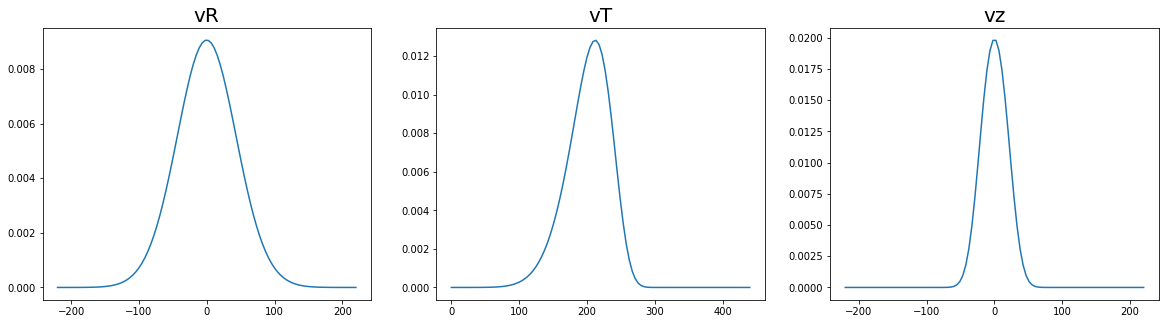

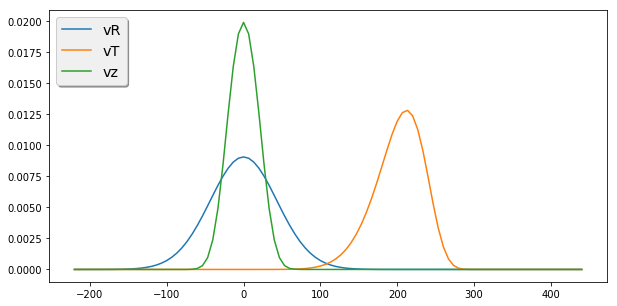

In [18]:
from galpy.df import quasiisothermaldf
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import actionAngleAdiabatic
import numpy 

aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.45,c=True)
qdfS= quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aAS,cutcounter=True)

#initialize mean values for (R,vR,vT,z,vz)
mR,mz = 8.3/8. ,0./8. #convert to nat. units

vRs= np.linspace(-1,1,100) #odd endpoints because galpy uses natural units
vTs= np.linspace(0,2,100)
vzs= np.linspace(-1,1,100)

#Calculating the probability of vR without regard for vT or vz 
#is called marginalizing over the remaining probabilities.
#This is the opposite of conditional probability. 

pvR= np.array([qdfS.pvR(vR,mR,mz) for vR in vRs]) #uses Gauss-Legendre integration
pvT= np.array([qdfS.pvT(vT,mR,mz) for vT in vTs])
pvz= np.array([qdfS.pvz(vz,mR,mz) for vz in vzs])

#plot!
fig, ax = plt.subplots(1, 3, sharex='none', sharey='none', figsize=(20,5))

ax[0].plot(vRs*220, pvR/numpy.sum(pvR)/(vRs[1]-vRs[0])/220) #convert to physical units and normalize area to 1 
ax[0].set_title('vR', fontsize=20)
ax[1].plot(vTs*220, pvT/numpy.sum(pvT)/(vTs[1]-vTs[0])/220)
ax[1].set_title('vT', fontsize=20)
ax[2].plot(vRs*220, pvz/numpy.sum(pvR)/(vzs[1]-vzs[0])/220)
ax[2].set_title('vz', fontsize=20)


#above graphs overlayed
vs= np.linspace(-1,2,100)

pvR= np.array([qdfS.pvR(v,mR,mz) for v in vs])
pvT= np.array([qdfS.pvT(v,mR,mz) for v in vs])
pvz= np.array([qdfS.pvz(v,mR,mz) for v in vs])

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, label='vR') #convert to physical units and normalize area to 1 
ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, label='vT')
ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, label='vz')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
plt.show()

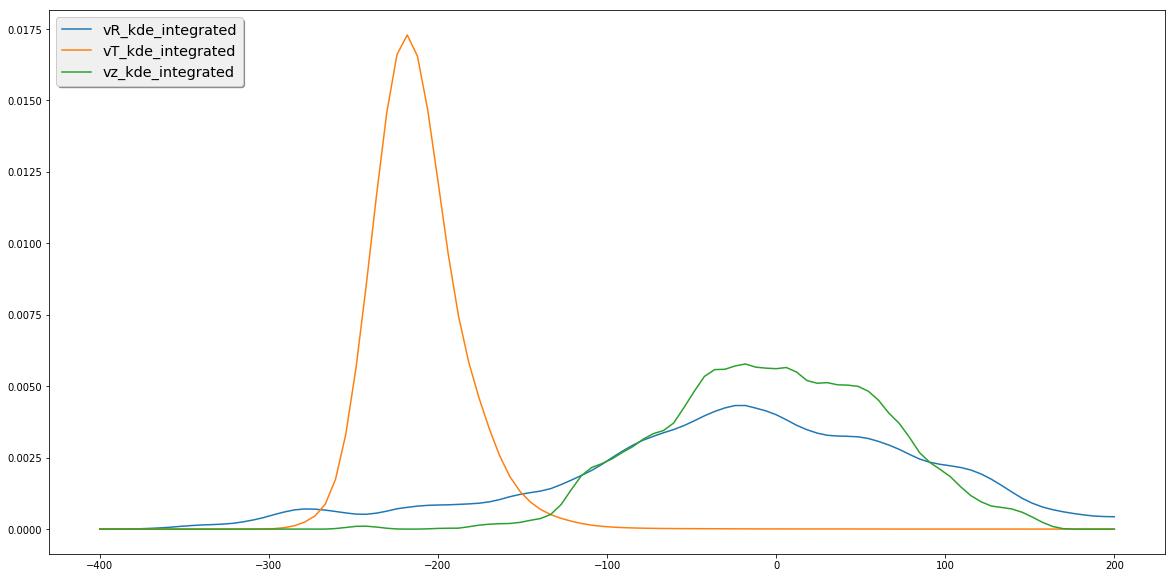

In [20]:
import numpy as np
# overplotting qdf and kde integrated
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR_kde_integrated') #normalized area to 1
ax.plot(v_input, vT_output/np.sum(vT_output)/(v_input[1]-v_input[0]), label='vT_kde_integrated')
ax.plot(v_input, vz_output/np.sum(vz_output)/(v_input[1]-v_input[0]), label='vz_kde_integrated')
#ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, label='vR_qdf_integrated')
#ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, label='vT_qdf_integrated')
#ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, label='vz_qdf_integrated')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
#plt.savefig('gaia_zscore_cyl_integrated')
plt.show()

In [5]:
from scipy.integrate import dblquad
import time

#input values for velocities (vR, vT, vz)
v_input = np.linspace(-400, 200, 100)

# -----------------
# Integrate over vR
# -----------------

def kde_gaia_cyl_vR(vT, vz, R, phi, z, vR):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vR(kde_gaia_epanechnikov, vR): #bounds of vT = [-300, 0], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_gaia_cyl_vR, -300, 0, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.0001)  # args=(R, phi, z, vR)

vR_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_gaia_epanechnikov, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_gaia_cyl_vT(vR, vz, R, phi, z, vT):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vT(kde_gaia_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_gaia_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_gaia_epanechnikov, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_gaia_cyl_vz(vR, vT, R, phi, z, vz):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vz(kde_gaia_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [-300, 0]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_gaia_cyl_vz, -100, 100, -300, 0, args=([8.3, 3.14, 0., vz]), epsabs=0.0001)  # args=(R, phi, z, vR)

vz_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_gaia_epanechnikov, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].
KDE Evaluations along vR from [-400, 200] over 100 subintervals.

Evaluation: 1
Evaluating at vR = -400.0
Value: 1.1429363375066618e-14
Time to integrate: 2.77s
Time elapsed: 0.05 min

Evaluation: 2
Evaluating at vR = -393.93939393939394
Value: 2.3156725592596382e-07
Time to integrate: 3.04s
Time elapsed: 0.1 min

Evaluation: 3
Evaluating at vR = -387.8787878787879
Value: 5.095402169670986e-06
Time to integrate: 4.78s
Time elapsed: 0.18 min

Evaluation: 4
Evaluating at vR = -381.8181818181818
Value: 1.4836732262560467e-05
Time to integrate: 4.31s
Time elapsed: 0.25 min

Evaluation: 5
Evaluating at vR = -375.75757575757575
Value: 3.0198710554233322e-05
Time to integrate: 4.79s
Time elapsed: 0.33 min

Evaluation: 6
Evaluating at vR = -369.6969696969697
Value: 6.105592231345607e-05
Time to integrate: 4.61s
Time elapsed: 0.4 min

Evaluation: 7
Evaluating at vR = -363.6363636363636
Value: 0.000101133

Value: 0.009709550435260466
Time to integrate: 25.02s
Time elapsed: 20.44 min

Evaluation: 63
Evaluating at vR = -24.24242424242425
Value: 0.00989828407972379
Time to integrate: 17.17s
Time elapsed: 20.72 min

Evaluation: 64
Evaluating at vR = -18.181818181818187
Value: 0.009913345660570796
Time to integrate: 32.42s
Time elapsed: 21.26 min

Evaluation: 65
Evaluating at vR = -12.121212121212125
Value: 0.009711181335475775
Time to integrate: 38.58s
Time elapsed: 21.91 min

Evaluation: 66
Evaluating at vR = -6.060606060606062
Value: 0.009468841219818041
Time to integrate: 42.03s
Time elapsed: 22.61 min

Evaluation: 67
Evaluating at vR = 0.0
Value: 0.009167644983701604
Time to integrate: 38.68s
Time elapsed: 23.25 min

Evaluation: 68
Evaluating at vR = 6.060606060606062
Value: 0.008754687691509479
Time to integrate: 37.21s
Time elapsed: 23.87 min

Evaluation: 69
Evaluating at vR = 12.121212121212125
Value: 0.00831044723828514
Time to integrate: 39.33s
Time elapsed: 24.53 min

Evaluation: 7

Value: 1.7833801541712362
Time to integrate: 22.94s
Time elapsed: 2.5 min

Evaluation: 25
Evaluating at vT = -254.54545454545456
Value: 3.391286244844407
Time to integrate: 32.04s
Time elapsed: 3.03 min

Evaluation: 26
Evaluating at vT = -248.4848484848485
Value: 5.773402453164271
Time to integrate: 22.66s
Time elapsed: 3.41 min

Evaluation: 27
Evaluating at vT = -242.42424242424244
Value: 8.74148754676002
Time to integrate: 60.82s
Time elapsed: 4.43 min

Evaluation: 28
Evaluating at vT = -236.36363636363637
Value: 11.953519158099033
Time to integrate: 49.15s
Time elapsed: 5.24 min

Evaluation: 29
Evaluating at vT = -230.3030303030303
Value: 14.91364530092127
Time to integrate: 42.12s
Time elapsed: 5.95 min

Evaluation: 30
Evaluating at vT = -224.24242424242425
Value: 16.999087382961065
Time to integrate: 68.71s
Time elapsed: 7.09 min

Evaluation: 31
Evaluating at vT = -218.1818181818182
Value: 17.703723049531813
Time to integrate: 159.93s
Time elapsed: 9.76 min

Evaluation: 32
Evaluat

Value: 0.0011757580439220794
Time to integrate: 4.73s
Time elapsed: 22.65 min

Evaluation: 89
Evaluating at vT = 133.33333333333337
Value: 0.001049073482764209
Time to integrate: 4.7s
Time elapsed: 22.73 min

Evaluation: 90
Evaluating at vT = 139.39393939393938
Value: 0.0009777887137138116
Time to integrate: 4.75s
Time elapsed: 22.81 min

Evaluation: 91
Evaluating at vT = 145.4545454545455
Value: 0.0008767659936409619
Time to integrate: 4.84s
Time elapsed: 22.89 min

Evaluation: 92
Evaluating at vT = 151.5151515151515
Value: 0.0007201862315017978
Time to integrate: 4.74s
Time elapsed: 22.97 min

Evaluation: 93
Evaluating at vT = 157.57575757575762
Value: 0.000547581649532463
Time to integrate: 4.45s
Time elapsed: 23.05 min

Evaluation: 94
Evaluating at vT = 163.63636363636363
Value: 0.0003669456740824299
Time to integrate: 4.57s
Time elapsed: 23.12 min

Evaluation: 95
Evaluating at vT = 169.69696969696975
Value: 0.0002300055230974696
Time to integrate: 1.51s
Time elapsed: 23.15 min

Ev

Value: 0.006773660996109301
Time to integrate: 17.08s
Time elapsed: 6.95 min

Evaluation: 53
Evaluating at vz = -84.84848484848487
Value: 0.0072708866628574354
Time to integrate: 23.48s
Time elapsed: 7.34 min

Evaluation: 54
Evaluating at vz = -78.78787878787881
Value: 0.007926168728067475
Time to integrate: 19.99s
Time elapsed: 7.67 min

Evaluation: 55
Evaluating at vz = -72.72727272727275
Value: 0.008427598812483778
Time to integrate: 16.97s
Time elapsed: 7.96 min

Evaluation: 56
Evaluating at vz = -66.66666666666669
Value: 0.008703555170413834
Time to integrate: 4.91s
Time elapsed: 8.04 min

Evaluation: 57
Evaluating at vz = -60.60606060606062
Value: 0.009366287942595053
Time to integrate: 23.88s
Time elapsed: 8.44 min

Evaluation: 58
Evaluating at vz = -54.54545454545456
Value: 0.010728111091823653
Time to integrate: 16.93s
Time elapsed: 8.72 min

Evaluation: 59
Evaluating at vz = -48.4848484848485
Value: 0.012151973869940762
Time to integrate: 31.18s
Time elapsed: 9.24 min

Evalua

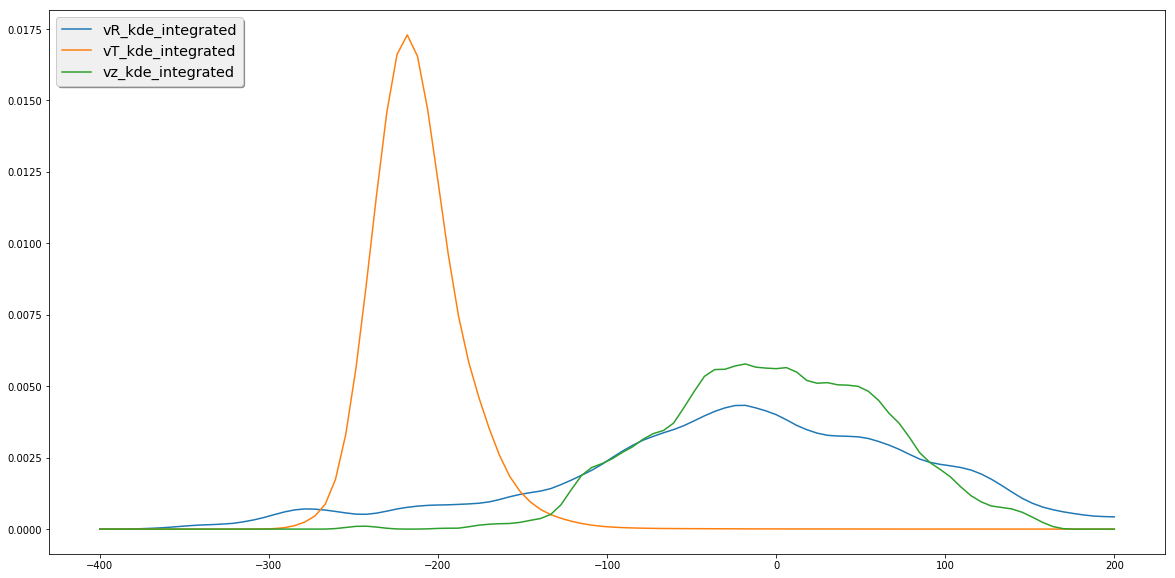

In [6]:
import numpy as np
# overplotting qdf and kde integrated
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR_kde_integrated') #normalized area to 1
ax.plot(v_input, vT_output/np.sum(vT_output)/(v_input[1]-v_input[0]), label='vT_kde_integrated')
ax.plot(v_input, vz_output/np.sum(vz_output)/(v_input[1]-v_input[0]), label='vz_kde_integrated')
#ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, label='vR_qdf_integrated')
#ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, label='vT_qdf_integrated')
#ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, label='vz_qdf_integrated')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
#plt.savefig('gaia_zscore_cyl_integrated')
plt.show()

In [ ]:
from scipy.integrate import dblquad
import time

#input values for velocities (vR, vT, vz)
v_input = np.linspace(-400, 200, 100)

# -----------------
# Integrate over vR
# -----------------

def kde_gaia_cyl_vR(vT, vz, R, phi, z, vR):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vR(kde_gaia_epanechnikov, vR): #bounds of vT = [-300, 0], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_gaia_cyl_vR, -300, 0, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.0001)  # args=(R, phi, z, vR)

vR_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_gaia_epanechnikov, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_gaia_cyl_vT(vR, vz, R, phi, z, vT):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vT(kde_gaia_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_gaia_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_gaia_epanechnikov, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_gaia_cyl_vz(vR, vT, R, phi, z, vz):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vz(kde_gaia_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [-300, 0]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_gaia_cyl_vz, -100, 100, -300, 0, args=([8.3, 3.14, 0., vz]), epsabs=0.0001)  # args=(R, phi, z, vR)

vz_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_gaia_epanechnikov, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()